In [2]:
EEG_channels = 22 #from project guidelines
test_count = 50 #from project guideline, 238 for train-validation and 50 for test
validation_count = 38 # 38 points in validation set and remaining 200 points in test set

In [3]:
from includes import *

#################### "includes" imports:
#
#   from read_data import *
#   
#   import torch
#   from torch.autograd import Variable
#   import torch.nn as nn
#   import torch.optim as optim
#
#   dtype = torch.cuda.FloatTensor # torch.FloatTensor
#
#   all_files = [h5py.File(m, 'r') for m in mat_names]
#   all_ims = [f['image'] for f in all_files]
#   all_types = [f['type'] for f in all_files]
#
####################
%load_ext autoreload
%autoreload 2

In [4]:
image_mat = all_ims[0]
image_shape = image_mat.shape # 288 (48x6) trials across 25 electrodes for 1000 time points (250Hz*4s)
print image_shape

(288, 25, 1000)


In [5]:
print(mat_names)

['./project_datasets/A01T_slice.mat', './project_datasets/A02T_slice.mat', './project_datasets/A03T_slice.mat', './project_datasets/A04T_slice.mat', './project_datasets/A05T_slice.mat', './project_datasets/A06T_slice.mat', './project_datasets/A07T_slice.mat', './project_datasets/A08T_slice.mat', './project_datasets/A09T_slice.mat']


In [6]:
#setting seed
np.random.seed(seed=1337)
test_picked = np.random.choice(image_shape[0], test_count, replace=False)
train_val_picked = np.setdiff1d(np.arange(image_shape[0]), test_picked)
val_picked = train_val_picked[:validation_count]
train_picked = train_val_picked[validation_count:]

In [7]:
type_mat = all_types[0]
type_shape = type_mat.shape
type_set = list(set(type_mat[0,:]))

# all the 0's occur after 288, and are meaningless I think
# so the image_mat, which has shape (288, 25, 1000) should correspond
# to the first 288 entries of type_mat, so
# for a single subject, training data should be image_mat, with 288 samples, each sample has shape (25, 1000)
# and our target label matrix should be type_mat[:288] (or 287?)

In [8]:
trainval_data_X = []
training_data_X = []
validation_data_X = []
test_data_X = []

trainval_data_Y = []
training_data_Y = []
validation_data_Y = []
test_data_Y = []

for i in range(len(mat_names)):
    matfile = h5py.File(mat_names[i], 'r')
    
    trainval_data_X.append(matfile['image'][sorted(train_val_picked),:EEG_channels,:]) #(238, 22, 1000) x 9
    training_data_X.append(matfile['image'][sorted(train_picked),:EEG_channels,:]) #(200, 22, 1000) x 9
    validation_data_X.append(matfile['image'][sorted(val_picked),:EEG_channels,:]) #(38, 22, 1000) x 9
    test_data_X.append(matfile['image'][sorted(test_picked),:EEG_channels,:]) #(50, 22, 1000) x 9
    
    trainval_data_Y.append(matfile['type'][0,sorted(train_val_picked)] - type_set[1]) #(238, ) x 9
    training_data_Y.append(matfile['type'][0,sorted(train_picked)] - type_set[1]) #(200, ) x 9
    validation_data_Y.append(matfile['type'][0,sorted(val_picked)] - type_set[1]) #(38, ) x 9
    test_data_Y.append(matfile['type'][0,sorted(test_picked)] - type_set[1]) #(50, ) x 9

In [9]:
for i in range(len(mat_names)):
    assert(set(training_data_Y[i]) == set(validation_data_Y[i])) #check whether we have data for all labels 
    assert(set(training_data_Y[i]) == set(test_data_Y[i])) #check whether we have data for all labels 

In [10]:
from functools import reduce

rnn_trainval_data_X = np.concatenate(trainval_data_X, axis=0) #(2142, 22, 1000)
rnn_training_data_X = np.concatenate(training_data_X, axis=0) #(1800, 22, 1000)
rnn_validation_data_X = np.concatenate(validation_data_X, axis=0) #(342, 22, 1000)
rnn_test_data_X = np.concatenate(test_data_X, axis=0) #(450, 22, 1000)

rnn_trainval_data_Y = np.concatenate(trainval_data_Y, axis=0) #(2142, )
rnn_training_data_Y = np.concatenate(training_data_Y, axis=0) #(1800, )
rnn_validation_data_Y = np.concatenate(validation_data_Y, axis=0) #(342, )
rnn_test_data_Y = np.concatenate(test_data_Y, axis=0) #(450,)

def remove_nan_rows_A(A, b, debug=True):
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    if (np.isnan(A).any() or np.isnan(b).any()):
        mask = ~np.isnan(np.sum(A,axis=(1,2))) & ~np.isnan(b[:])
        A = A[mask, :, :]
        b = b[mask]
    
    if (debug):
        print('before nans: {}'.format(str(A.shape)))
    assert A.shape[0] == b.shape[0]
    return A, b

rnn_trainval_data_X, rnn_trainval_data_Y = remove_nan_rows_A(rnn_trainval_data_X,
                                                             rnn_trainval_data_Y)
rnn_training_data_X, rnn_training_data_Y = remove_nan_rows_A(rnn_training_data_X, 
                                                             rnn_training_data_Y)
rnn_validation_data_X, rnn_validation_data_Y = remove_nan_rows_A(rnn_validation_data_X,
                                         rnn_validation_data_Y)
rnn_test_data_X, rnn_test_data_Y = remove_nan_rows_A(rnn_test_data_X,
                                   rnn_test_data_Y)

N_trainval, E, T = rnn_trainval_data_X.shape
N_training, _, _ = rnn_trainval_data_X.shape
N_validation, _, _ = rnn_test_data_X.shape
N_test, _, _ = rnn_test_data_X.shape

before nans: (2142, 22, 1000)
before nans: (2115, 22, 1000)
before nans: (1800, 22, 1000)
before nans: (1775, 22, 1000)
before nans: (342, 22, 1000)
before nans: (340, 22, 1000)
before nans: (450, 22, 1000)
before nans: (443, 22, 1000)


In [11]:
print(training_data_Y[0].shape)

(200,)


In [12]:
training_data_shape = training_data_X[0].shape
print(training_data_shape) #(200, 22, 1000) while test data shape is (50, 22, 1000) and validation data is (38, 22,1000)

(200, 22, 1000)


In [13]:
print rnn_trainval_data_X.shape
print rnn_trainval_data_Y.shape

(2115, 22, 1000)
(2115,)


In [14]:
from torch.nn.utils.rnn import pack_padded_sequence as ppseq

In [15]:
tensor_x_train = torch.Tensor(rnn_training_data_X)
tensor_y_train = torch.LongTensor(rnn_training_data_Y)

print tensor_x_train.shape
print tensor_y_train.shape

tensor_x_val = torch.Tensor(rnn_validation_data_X)
tensor_y_val = torch.LongTensor(rnn_validation_data_Y)

torch.Size([1775, 22, 1000])
torch.Size([1775])


In [16]:
import torch.utils.data

In [82]:
# Dataset Hyper Parameters
num_epochs = 30
batch_size = 100

In [83]:
train_dataset = torch.utils.data.TensorDataset(tensor_x_train,tensor_y_train)
val_dataset = torch.utils.data.TensorDataset(tensor_x_val,tensor_y_val)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

In [85]:
# Optimizer Hyper Parameters
learning_rate = 1e-3
reg_hidden_weight = 1.0
reg_weight_size = 0.01
NUM_CLASSES = 4

# Debug Parameters
VERBOSE = False
PRINT_GRADS = False

from VanillaRNN import VanillaRNN

net = VanillaRNN(
                conv_layers = True,
                initial_hidden_layer_sizes = [],#[100],#[100],
                recurrent_hidden_size = 32,
                recurrent_use_bias = True,
                recurrent_layer_num = 2,
                #recurrent_dropout = 0.25,
                final_hidden_layer_sizes = [],#[100, 10],
                num_classes=NUM_CLASSES,
                verbose = VERBOSE)

FCC_SANITY = False

#from FC import FC
#net = FC()
#FCC_SANITY = True

net.initialize_weights()

criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.RMSprop(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)#, weight_decay=0.01)


#optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)


for s in net.parameters():
    print('{}'.format(s.shape))
    

torch.Size([22])
torch.Size([22])
torch.Size([16, 22, 25])
torch.Size([16])
torch.Size([8, 16, 25])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([128, 8])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([64])
torch.Size([64])
torch.Size([4, 64])
torch.Size([4])


torch.Size([1775, 4])


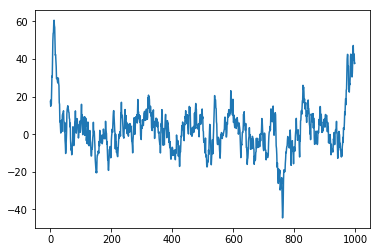

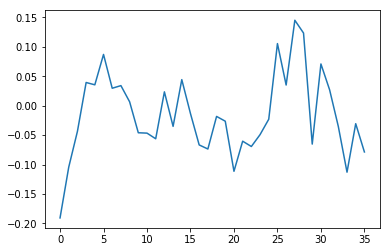

torch.Size([1775, 64])


In [86]:
net.train(True)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:
    out, hidden = net.forward(tensor_x_train)
print(out.shape)
net.train(False)

if (FCC_SANITY):
    out = net.forward(tensor_x_train)
else:    
    out, hidden = net.forward(tensor_x_train)
    
print(net.rnn_out.shape)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:63: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:65: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch [1/30], Iter [1/17] Loss: [----- 1.3859 = 1.3859 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [2/17] Loss: [----- 1.4062 = 1.4062 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [3/17] Loss: [----- 1.4027 = 1.4027 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [4/17] Loss: [----- 1.4181 = 1.4181 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [5/17] Loss: [----- 1.4485 = 1.4485 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [6/17] Loss: [----- 1.3576 = 1.3576 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [7/17] Loss: [----- 1.4159 = 1.4159 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [8/17] Loss: [----- 1.4047 = 1.4047 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [9/17] Loss: [----- 1.4150 = 1.4150 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [10/17] Loss: [----- 1.3961 = 1.3961 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [1/30], Iter [11/17] Loss: [----- 1.4053 = 

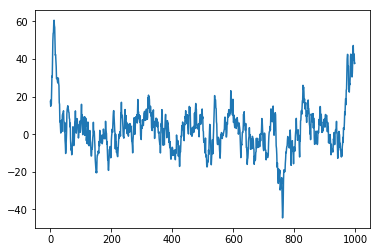

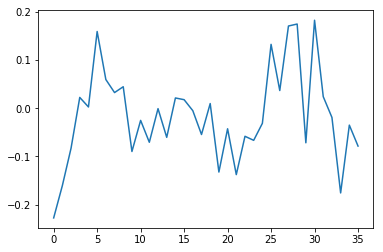

torch.Size([1775, 4])
Train Accuracy: 26 %


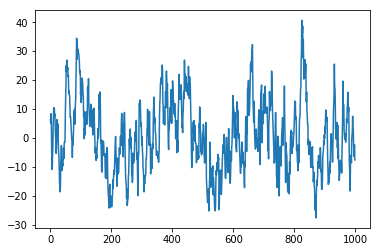

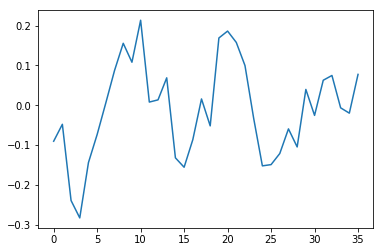

predicted set [0 2]
label set [0 1 2 3]
validation Accuracy: 24 %
Epoch [2/30], Iter [1/17] Loss: [----- 1.3597 = 1.3597 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [2/17] Loss: [----- 1.3821 = 1.3821 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [3/17] Loss: [----- 1.3795 = 1.3795 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [4/17] Loss: [----- 1.3859 = 1.3859 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [5/17] Loss: [----- 1.3918 = 1.3918 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [6/17] Loss: [----- 1.3863 = 1.3863 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [7/17] Loss: [----- 1.4196 = 1.4196 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [8/17] Loss: [----- 1.3632 = 1.3632 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [9/17] Loss: [----- 1.3655 = 1.3655 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [2/30], Iter [10/17] Loss: [----- 1.3997 = 1.3997 + 1.00 * 1.6046 + 0.01 

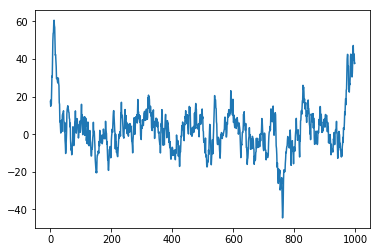

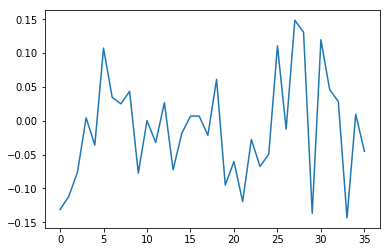

torch.Size([1775, 4])
Train Accuracy: 27 %


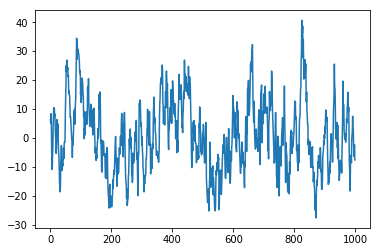

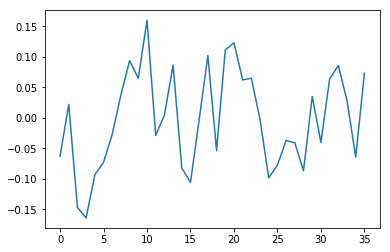

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 26 %
Epoch [3/30], Iter [1/17] Loss: [----- 1.3867 = 1.3867 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [2/17] Loss: [----- 1.3624 = 1.3624 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [3/17] Loss: [----- 1.3756 = 1.3756 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [4/17] Loss: [----- 1.3512 = 1.3512 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [5/17] Loss: [----- 1.3658 = 1.3658 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [6/17] Loss: [----- 1.3675 = 1.3675 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [7/17] Loss: [----- 1.3708 = 1.3708 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [8/17] Loss: [----- 1.3672 = 1.3672 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [9/17] Loss: [----- 1.3797 = 1.3797 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [3/30], Iter [10/17] Loss: [----- 1.3678 = 1.3678 + 1.00 * 1.6046 + 0

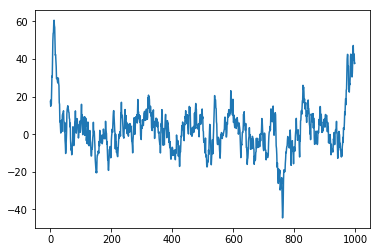

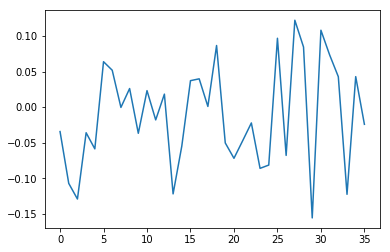

torch.Size([1775, 4])
Train Accuracy: 31 %


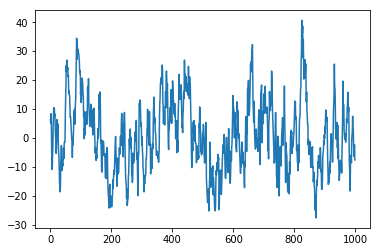

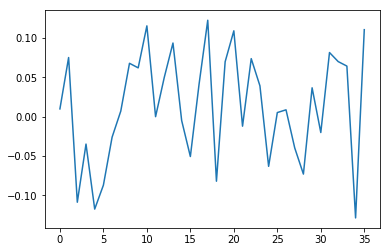

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
Epoch [4/30], Iter [1/17] Loss: [----- 1.3546 = 1.3546 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [2/17] Loss: [----- 1.3529 = 1.3529 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [3/17] Loss: [----- 1.3338 = 1.3338 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [4/17] Loss: [----- 1.3570 = 1.3570 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [5/17] Loss: [----- 1.3398 = 1.3398 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [6/17] Loss: [----- 1.4040 = 1.4040 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [7/17] Loss: [----- 1.3653 = 1.3653 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [8/17] Loss: [----- 1.3794 = 1.3794 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [9/17] Loss: [----- 1.3637 = 1.3637 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [4/30], Iter [10/17] Loss: [----- 1.3762 = 1.3762 + 1.00 * 1.6046 + 0

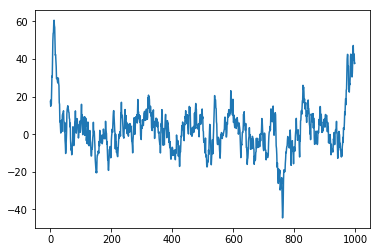

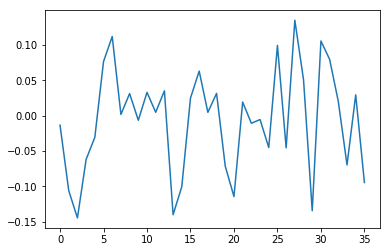

torch.Size([1775, 4])
Train Accuracy: 33 %


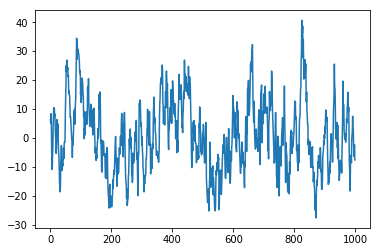

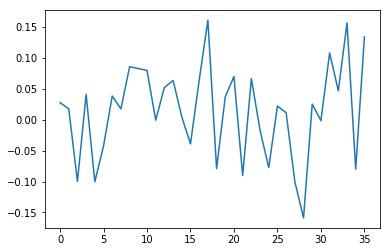

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [5/30], Iter [1/17] Loss: [----- 1.3278 = 1.3278 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [2/17] Loss: [----- 1.3681 = 1.3681 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [3/17] Loss: [----- 1.3187 = 1.3187 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [4/17] Loss: [----- 1.3184 = 1.3184 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [5/17] Loss: [----- 1.3503 = 1.3503 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [6/17] Loss: [----- 1.3275 = 1.3275 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [7/17] Loss: [----- 1.3096 = 1.3096 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [8/17] Loss: [----- 1.3900 = 1.3900 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [9/17] Loss: [----- 1.3426 = 1.3426 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [5/30], Iter [10/17] Loss: [----- 1.3557 = 1.3557 + 1.00 * 1.6046 + 0

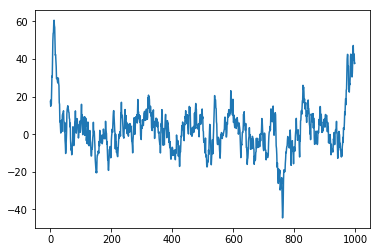

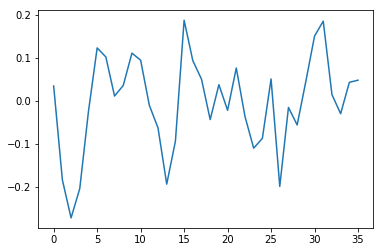

torch.Size([1775, 4])
Train Accuracy: 35 %


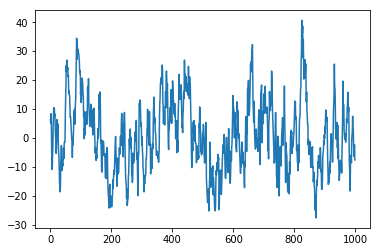

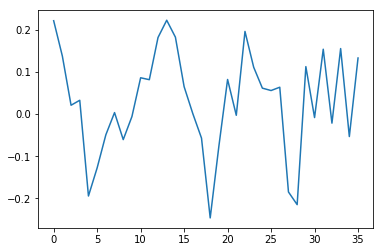

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
Epoch [6/30], Iter [1/17] Loss: [----- 1.2958 = 1.2958 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [2/17] Loss: [----- 1.3435 = 1.3435 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [3/17] Loss: [----- 1.3513 = 1.3513 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [4/17] Loss: [----- 1.3694 = 1.3694 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [5/17] Loss: [----- 1.2738 = 1.2738 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [6/17] Loss: [----- 1.3167 = 1.3167 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [7/17] Loss: [----- 1.3555 = 1.3555 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [8/17] Loss: [----- 1.3680 = 1.3680 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [9/17] Loss: [----- 1.3546 = 1.3546 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [6/30], Iter [10/17] Loss: [----- 1.3253 = 1.3253 + 1.00 * 1.6046 + 0

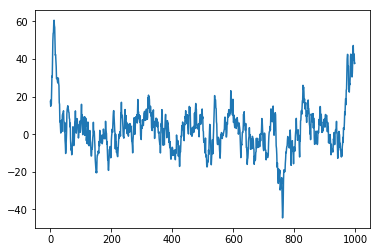

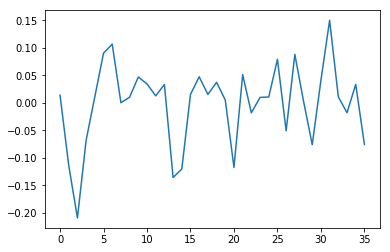

torch.Size([1775, 4])
Train Accuracy: 38 %


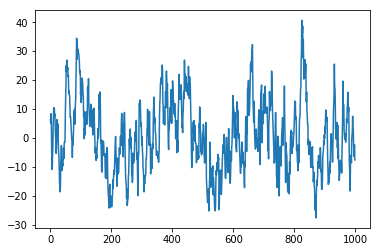

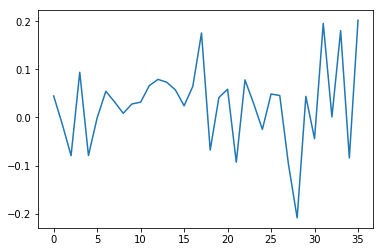

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
Epoch [7/30], Iter [1/17] Loss: [----- 1.3271 = 1.3271 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [2/17] Loss: [----- 1.3347 = 1.3347 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [3/17] Loss: [----- 1.3210 = 1.3210 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [4/17] Loss: [----- 1.2795 = 1.2795 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [5/17] Loss: [----- 1.3212 = 1.3212 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [6/17] Loss: [----- 1.3157 = 1.3157 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [7/17] Loss: [----- 1.3382 = 1.3382 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [8/17] Loss: [----- 1.3184 = 1.3184 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [9/17] Loss: [----- 1.2776 = 1.2776 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [7/30], Iter [10/17] Loss: [----- 1.3191 = 1.3191 + 1.00 * 1.6046 + 0

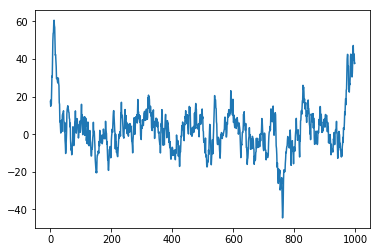

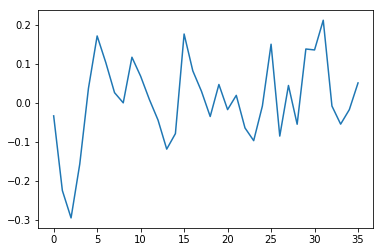

torch.Size([1775, 4])
Train Accuracy: 39 %


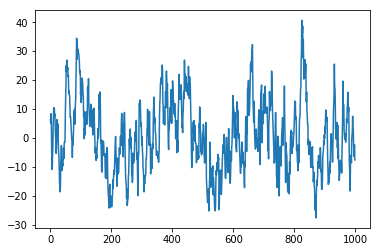

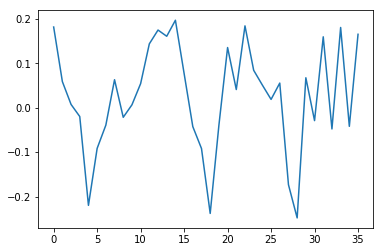

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [8/30], Iter [1/17] Loss: [----- 1.2329 = 1.2329 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [2/17] Loss: [----- 1.2624 = 1.2624 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [3/17] Loss: [----- 1.2997 = 1.2997 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [4/17] Loss: [----- 1.2913 = 1.2913 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [5/17] Loss: [----- 1.3068 = 1.3068 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [6/17] Loss: [----- 1.2668 = 1.2668 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [7/17] Loss: [----- 1.3426 = 1.3426 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [8/17] Loss: [----- 1.2961 = 1.2961 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [9/17] Loss: [----- 1.3023 = 1.3023 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [8/30], Iter [10/17] Loss: [----- 1.3003 = 1.3003 + 1.00 * 1.6046 + 0

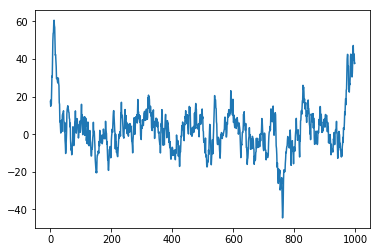

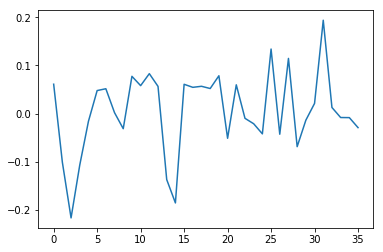

torch.Size([1775, 4])
Train Accuracy: 40 %


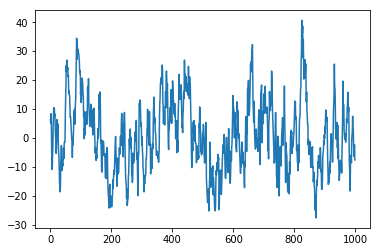

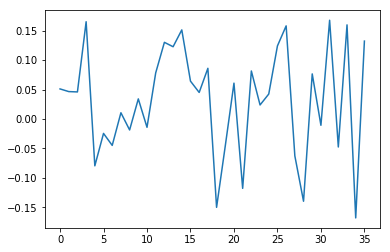

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
Epoch [9/30], Iter [1/17] Loss: [----- 1.2493 = 1.2493 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [2/17] Loss: [----- 1.2578 = 1.2578 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [3/17] Loss: [----- 1.3206 = 1.3206 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [4/17] Loss: [----- 1.2467 = 1.2467 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [5/17] Loss: [----- 1.2671 = 1.2671 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [6/17] Loss: [----- 1.2596 = 1.2596 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [7/17] Loss: [----- 1.2120 = 1.2120 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [8/17] Loss: [----- 1.2393 = 1.2393 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [9/17] Loss: [----- 1.2600 = 1.2600 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [9/30], Iter [10/17] Loss: [----- 1.2667 = 1.2667 + 1.00 * 1.6046 + 0

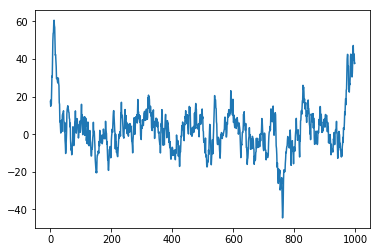

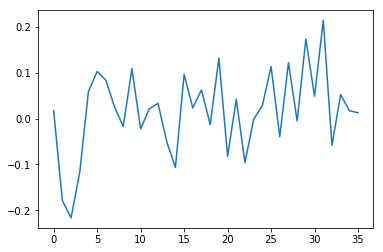

torch.Size([1775, 4])
Train Accuracy: 42 %


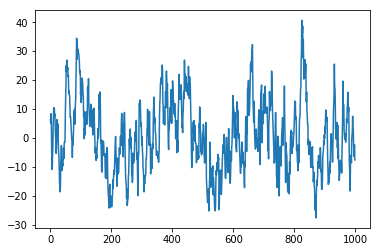

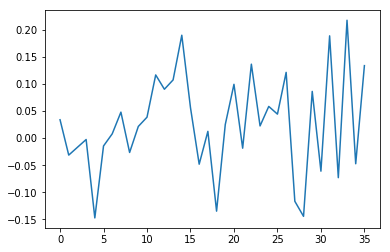

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 26 %
Epoch [10/30], Iter [1/17] Loss: [----- 1.2431 = 1.2431 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [2/17] Loss: [----- 1.2032 = 1.2032 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [3/17] Loss: [----- 1.2809 = 1.2809 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [4/17] Loss: [----- 1.1837 = 1.1837 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [5/17] Loss: [----- 1.2593 = 1.2593 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [6/17] Loss: [----- 1.2468 = 1.2468 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [7/17] Loss: [----- 1.2407 = 1.2407 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [8/17] Loss: [----- 1.2082 = 1.2082 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [9/17] Loss: [----- 1.2265 = 1.2265 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [10/30], Iter [10/17] Loss: [----- 1.3295 = 1.3295 + 1.00 * 

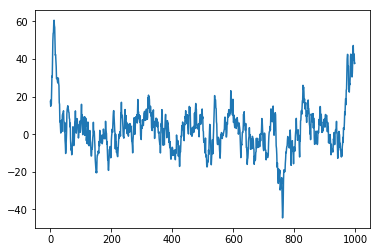

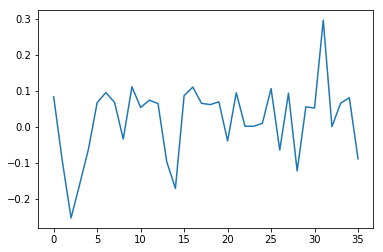

torch.Size([1775, 4])
Train Accuracy: 44 %


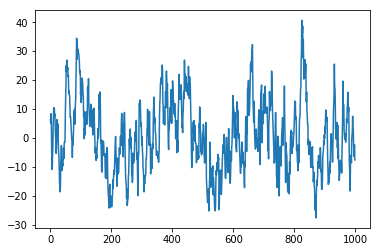

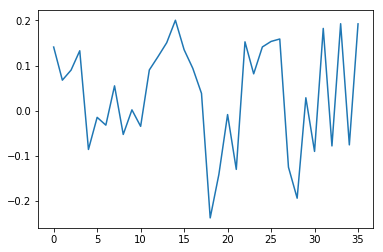

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [11/30], Iter [1/17] Loss: [----- 1.2609 = 1.2609 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [2/17] Loss: [----- 1.2164 = 1.2164 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [3/17] Loss: [----- 1.2907 = 1.2907 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [4/17] Loss: [----- 1.2803 = 1.2803 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [5/17] Loss: [----- 1.2873 = 1.2873 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [6/17] Loss: [----- 1.2675 = 1.2675 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [7/17] Loss: [----- 1.2350 = 1.2350 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [8/17] Loss: [----- 1.1087 = 1.1087 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [9/17] Loss: [----- 1.2287 = 1.2287 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [11/30], Iter [10/17] Loss: [----- 1.2913 = 1.2913 + 1.00 * 

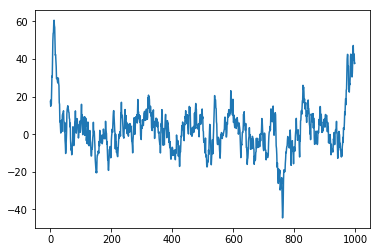

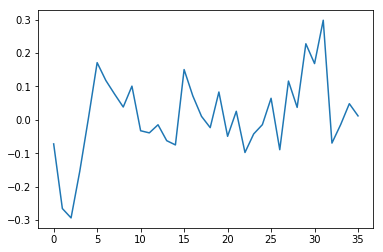

torch.Size([1775, 4])
Train Accuracy: 45 %


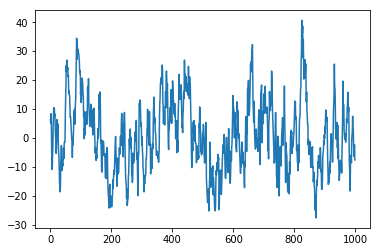

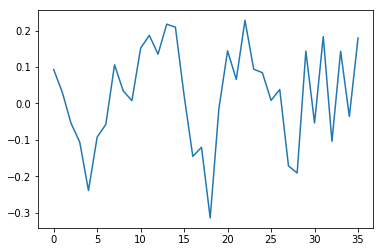

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [12/30], Iter [1/17] Loss: [----- 1.2372 = 1.2372 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [2/17] Loss: [----- 1.1471 = 1.1471 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [3/17] Loss: [----- 1.2151 = 1.2151 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [4/17] Loss: [----- 1.2056 = 1.2056 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [5/17] Loss: [----- 1.1552 = 1.1552 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [6/17] Loss: [----- 1.2567 = 1.2567 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [7/17] Loss: [----- 1.2596 = 1.2596 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [8/17] Loss: [----- 1.2062 = 1.2062 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [9/17] Loss: [----- 1.2052 = 1.2052 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [12/30], Iter [10/17] Loss: [----- 1.2427 = 1.2427 + 1.00 * 

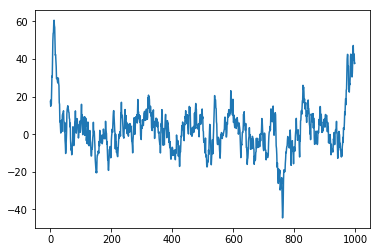

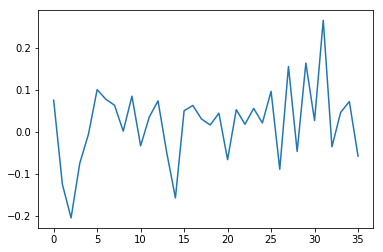

torch.Size([1775, 4])
Train Accuracy: 48 %


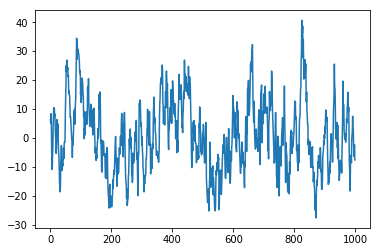

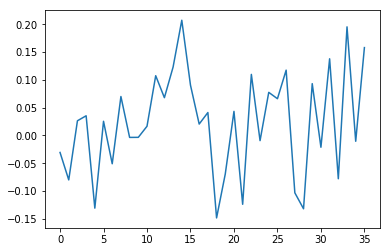

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [13/30], Iter [1/17] Loss: [----- 1.1387 = 1.1387 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [2/17] Loss: [----- 1.0957 = 1.0957 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [3/17] Loss: [----- 1.1422 = 1.1422 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [4/17] Loss: [----- 1.2633 = 1.2633 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [5/17] Loss: [----- 1.1679 = 1.1679 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [6/17] Loss: [----- 1.2234 = 1.2234 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [7/17] Loss: [----- 1.1769 = 1.1769 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [8/17] Loss: [----- 1.2328 = 1.2328 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [9/17] Loss: [----- 1.1311 = 1.1311 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [13/30], Iter [10/17] Loss: [----- 1.2184 = 1.2184 + 1.00 * 

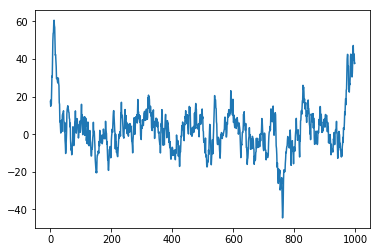

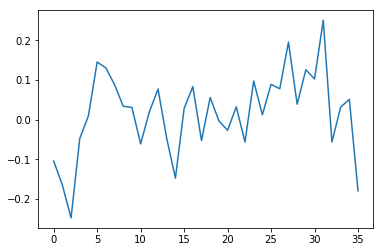

torch.Size([1775, 4])
Train Accuracy: 48 %


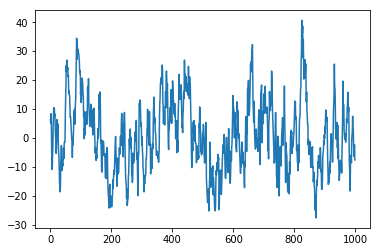

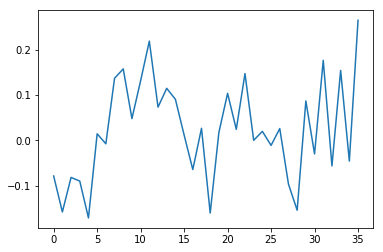

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [14/30], Iter [1/17] Loss: [----- 1.1239 = 1.1239 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [2/17] Loss: [----- 1.1039 = 1.1039 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [3/17] Loss: [----- 1.1834 = 1.1834 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [4/17] Loss: [----- 1.1114 = 1.1114 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [5/17] Loss: [----- 1.1438 = 1.1438 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [6/17] Loss: [----- 1.2737 = 1.2737 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [7/17] Loss: [----- 1.1236 = 1.1236 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [8/17] Loss: [----- 1.1668 = 1.1668 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [9/17] Loss: [----- 1.1407 = 1.1407 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [14/30], Iter [10/17] Loss: [----- 1.1518 = 1.1518 + 1.00 * 

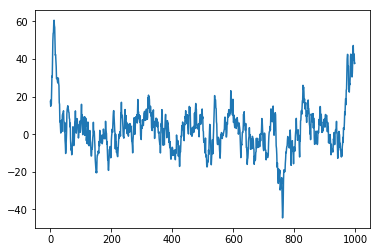

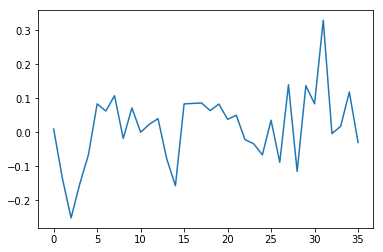

torch.Size([1775, 4])
Train Accuracy: 48 %


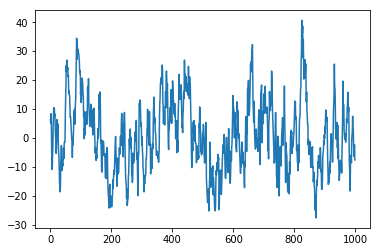

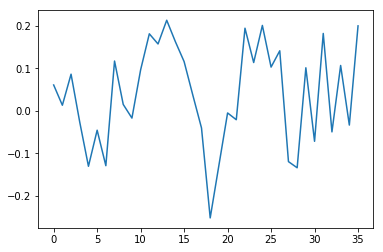

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [15/30], Iter [1/17] Loss: [----- 1.0476 = 1.0476 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [2/17] Loss: [----- 1.1017 = 1.1017 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [3/17] Loss: [----- 1.0997 = 1.0997 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [4/17] Loss: [----- 1.0717 = 1.0717 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [5/17] Loss: [----- 1.0669 = 1.0669 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [6/17] Loss: [----- 1.1213 = 1.1213 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [7/17] Loss: [----- 1.2236 = 1.2236 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [8/17] Loss: [----- 1.1069 = 1.1069 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [9/17] Loss: [----- 1.1845 = 1.1845 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [15/30], Iter [10/17] Loss: [----- 1.1679 = 1.1679 + 1.00 * 

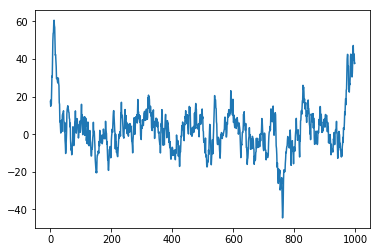

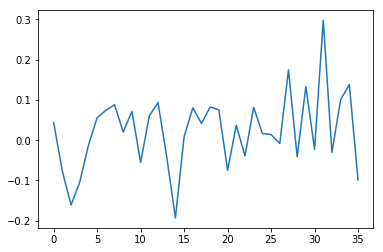

torch.Size([1775, 4])
Train Accuracy: 52 %


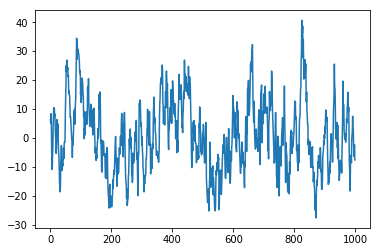

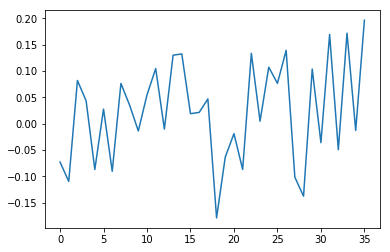

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 27 %
Epoch [16/30], Iter [1/17] Loss: [----- 1.0459 = 1.0459 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [2/17] Loss: [----- 1.0899 = 1.0899 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [3/17] Loss: [----- 1.1550 = 1.1550 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [4/17] Loss: [----- 1.0895 = 1.0895 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [5/17] Loss: [----- 1.1647 = 1.1647 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [6/17] Loss: [----- 1.1182 = 1.1182 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [7/17] Loss: [----- 1.1426 = 1.1426 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [8/17] Loss: [----- 1.1916 = 1.1916 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [9/17] Loss: [----- 1.1446 = 1.1446 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [16/30], Iter [10/17] Loss: [----- 1.1284 = 1.1284 + 1.00 * 

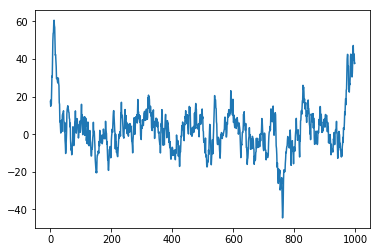

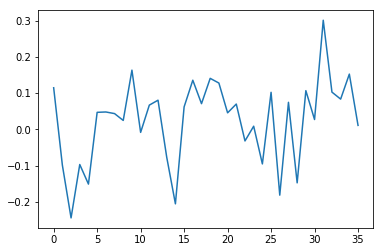

torch.Size([1775, 4])
Train Accuracy: 54 %


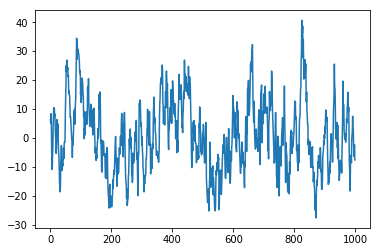

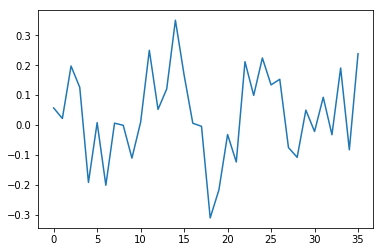

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 31 %
Epoch [17/30], Iter [1/17] Loss: [----- 1.0783 = 1.0783 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [2/17] Loss: [----- 1.0600 = 1.0600 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [3/17] Loss: [----- 1.0525 = 1.0525 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [4/17] Loss: [----- 1.1433 = 1.1433 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [5/17] Loss: [----- 1.0386 = 1.0386 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [6/17] Loss: [----- 1.1301 = 1.1301 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [7/17] Loss: [----- 1.1070 = 1.1070 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [8/17] Loss: [----- 1.0150 = 1.0150 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [9/17] Loss: [----- 1.0299 = 1.0299 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [17/30], Iter [10/17] Loss: [----- 1.2134 = 1.2134 + 1.00 * 

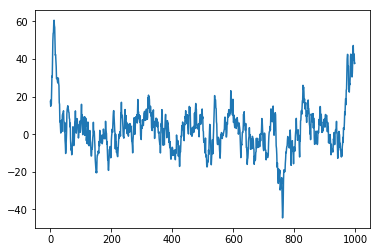

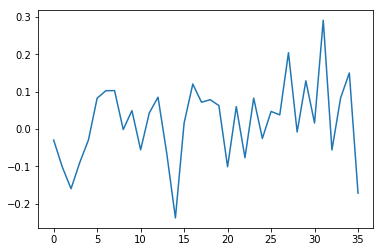

torch.Size([1775, 4])
Train Accuracy: 56 %


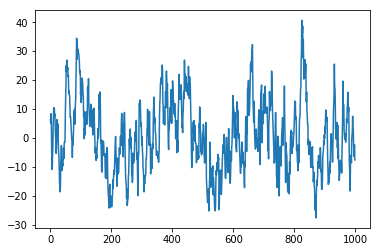

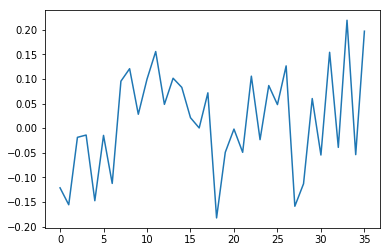

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [18/30], Iter [1/17] Loss: [----- 1.0438 = 1.0438 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [2/17] Loss: [----- 1.0409 = 1.0409 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [3/17] Loss: [----- 1.0514 = 1.0514 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [4/17] Loss: [----- 1.0494 = 1.0494 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [5/17] Loss: [----- 1.0413 = 1.0413 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [6/17] Loss: [----- 1.0330 = 1.0330 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [7/17] Loss: [----- 1.1691 = 1.1691 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [8/17] Loss: [----- 1.0944 = 1.0944 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [9/17] Loss: [----- 1.0624 = 1.0624 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [18/30], Iter [10/17] Loss: [----- 1.1182 = 1.1182 + 1.00 * 

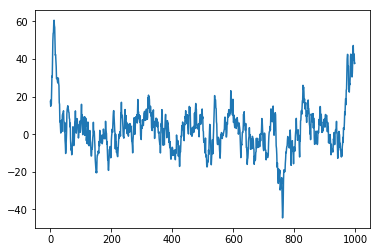

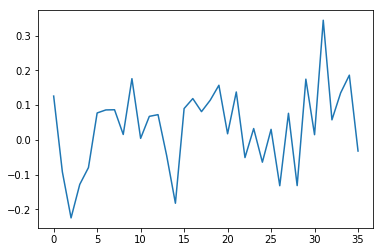

torch.Size([1775, 4])
Train Accuracy: 54 %


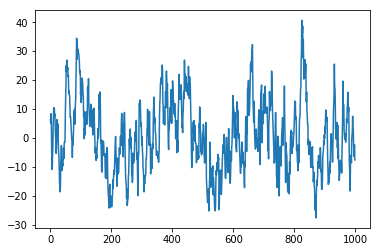

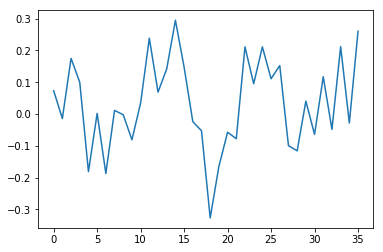

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [19/30], Iter [1/17] Loss: [----- 0.9595 = 0.9595 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [2/17] Loss: [----- 0.9837 = 0.9837 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [3/17] Loss: [----- 1.1038 = 1.1038 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [4/17] Loss: [----- 1.0326 = 1.0326 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [5/17] Loss: [----- 1.1429 = 1.1429 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [6/17] Loss: [----- 1.0735 = 1.0735 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [7/17] Loss: [----- 1.0952 = 1.0952 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [8/17] Loss: [----- 1.1374 = 1.1374 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [9/17] Loss: [----- 0.9694 = 0.9694 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [19/30], Iter [10/17] Loss: [----- 1.0867 = 1.0867 + 1.00 * 

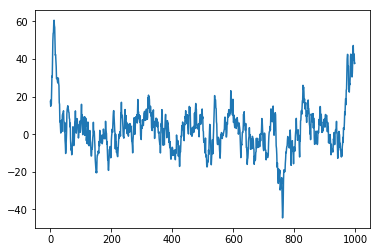

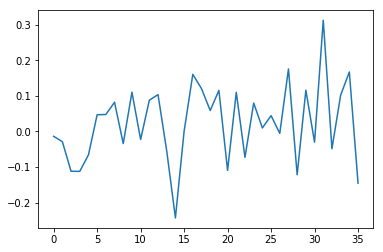

torch.Size([1775, 4])
Train Accuracy: 58 %


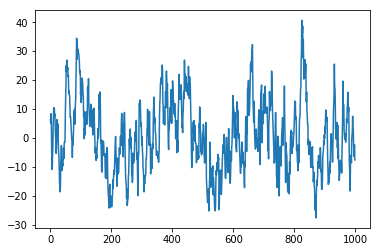

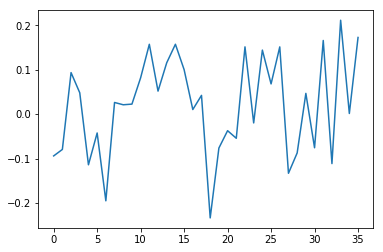

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [20/30], Iter [1/17] Loss: [----- 0.9217 = 0.9217 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [2/17] Loss: [----- 0.9178 = 0.9178 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [3/17] Loss: [----- 0.9972 = 0.9972 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [4/17] Loss: [----- 1.0310 = 1.0310 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [5/17] Loss: [----- 0.9159 = 0.9159 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [6/17] Loss: [----- 1.0327 = 1.0327 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [7/17] Loss: [----- 1.1351 = 1.1351 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [8/17] Loss: [----- 0.9745 = 0.9745 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [9/17] Loss: [----- 1.0255 = 1.0255 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [20/30], Iter [10/17] Loss: [----- 1.0470 = 1.0470 + 1.00 * 

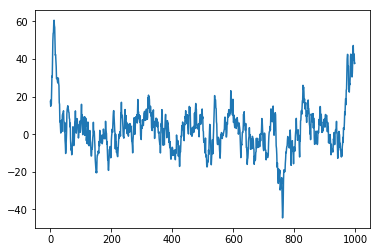

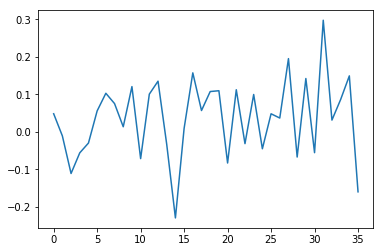

torch.Size([1775, 4])
Train Accuracy: 58 %


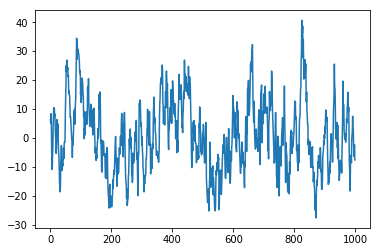

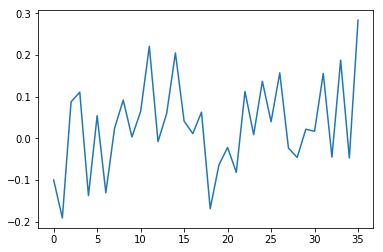

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [21/30], Iter [1/17] Loss: [----- 0.9479 = 0.9479 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [2/17] Loss: [----- 1.0298 = 1.0298 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [3/17] Loss: [----- 0.9242 = 0.9242 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [4/17] Loss: [----- 0.9636 = 0.9636 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [5/17] Loss: [----- 1.0333 = 1.0333 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [6/17] Loss: [----- 0.9583 = 0.9583 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [7/17] Loss: [----- 0.9957 = 0.9957 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [8/17] Loss: [----- 0.9602 = 0.9602 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [9/17] Loss: [----- 0.9087 = 0.9087 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [21/30], Iter [10/17] Loss: [----- 1.0299 = 1.0299 + 1.00 * 

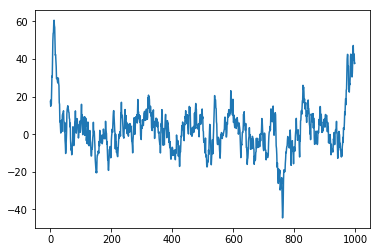

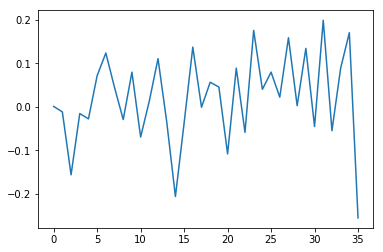

torch.Size([1775, 4])
Train Accuracy: 59 %


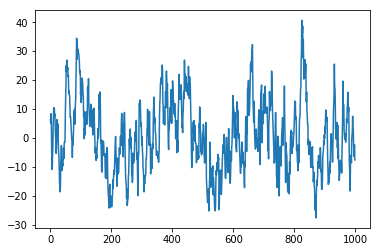

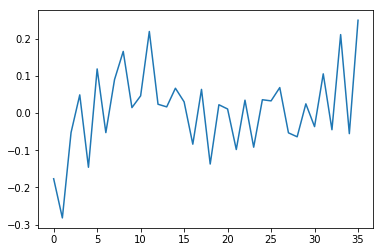

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 25 %
Epoch [22/30], Iter [1/17] Loss: [----- 1.0261 = 1.0261 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [2/17] Loss: [----- 1.1169 = 1.1169 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [3/17] Loss: [----- 1.0406 = 1.0406 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [4/17] Loss: [----- 0.9434 = 0.9434 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [5/17] Loss: [----- 0.9237 = 0.9237 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [6/17] Loss: [----- 0.9571 = 0.9571 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [7/17] Loss: [----- 0.9955 = 0.9955 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [8/17] Loss: [----- 0.8701 = 0.8701 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [9/17] Loss: [----- 0.9940 = 0.9940 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [22/30], Iter [10/17] Loss: [----- 0.8839 = 0.8839 + 1.00 * 

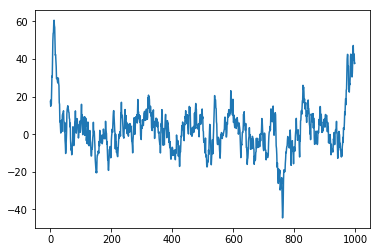

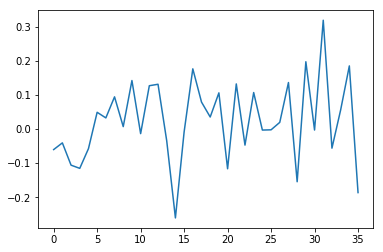

torch.Size([1775, 4])
Train Accuracy: 63 %


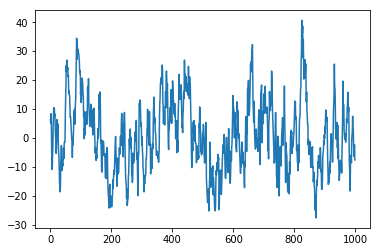

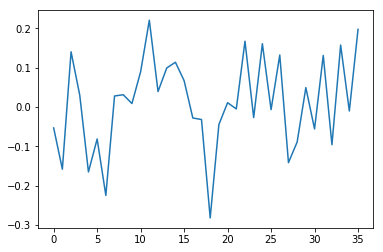

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [23/30], Iter [1/17] Loss: [----- 0.8692 = 0.8692 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [2/17] Loss: [----- 0.8722 = 0.8722 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [3/17] Loss: [----- 0.8850 = 0.8850 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [4/17] Loss: [----- 0.9274 = 0.9274 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [5/17] Loss: [----- 0.9430 = 0.9430 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [6/17] Loss: [----- 0.9588 = 0.9588 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [7/17] Loss: [----- 0.8853 = 0.8853 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [8/17] Loss: [----- 0.9953 = 0.9953 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [9/17] Loss: [----- 0.8011 = 0.8011 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [23/30], Iter [10/17] Loss: [----- 0.9617 = 0.9617 + 1.00 * 

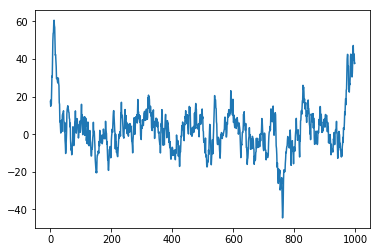

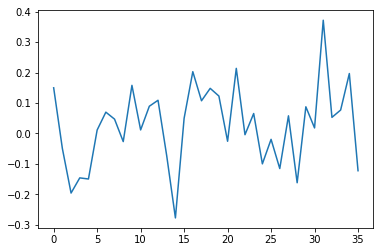

torch.Size([1775, 4])
Train Accuracy: 62 %


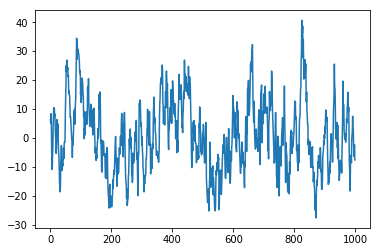

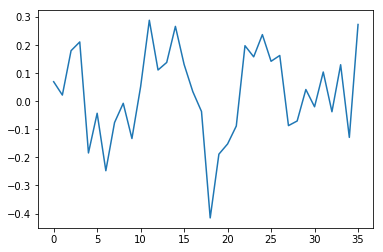

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [24/30], Iter [1/17] Loss: [----- 0.8833 = 0.8833 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [2/17] Loss: [----- 0.9734 = 0.9734 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [3/17] Loss: [----- 0.8608 = 0.8608 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [4/17] Loss: [----- 0.8498 = 0.8498 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [5/17] Loss: [----- 0.8510 = 0.8510 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [6/17] Loss: [----- 0.8252 = 0.8252 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [7/17] Loss: [----- 0.7868 = 0.7868 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [8/17] Loss: [----- 0.8593 = 0.8593 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [9/17] Loss: [----- 0.9347 = 0.9347 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [24/30], Iter [10/17] Loss: [----- 0.8655 = 0.8655 + 1.00 * 

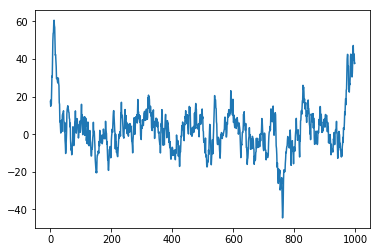

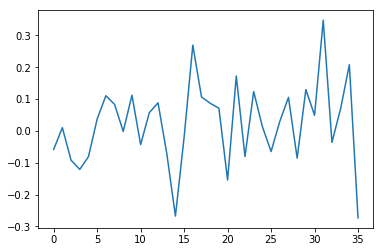

torch.Size([1775, 4])
Train Accuracy: 64 %


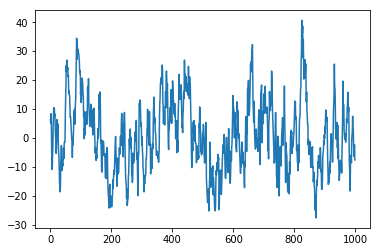

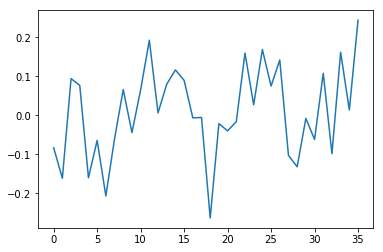

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [25/30], Iter [1/17] Loss: [----- 0.8663 = 0.8663 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [2/17] Loss: [----- 0.8448 = 0.8448 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [3/17] Loss: [----- 0.9889 = 0.9889 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [4/17] Loss: [----- 0.9098 = 0.9098 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [5/17] Loss: [----- 0.7949 = 0.7949 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [6/17] Loss: [----- 0.8822 = 0.8822 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [7/17] Loss: [----- 0.9288 = 0.9288 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [8/17] Loss: [----- 0.8452 = 0.8452 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [9/17] Loss: [----- 0.7883 = 0.7883 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [25/30], Iter [10/17] Loss: [----- 1.0182 = 1.0182 + 1.00 * 

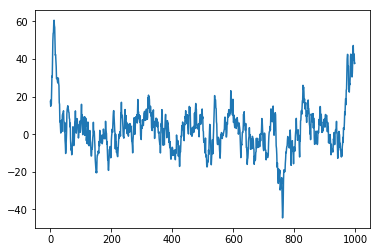

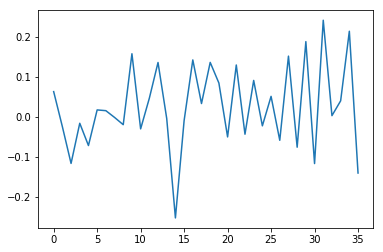

torch.Size([1775, 4])
Train Accuracy: 67 %


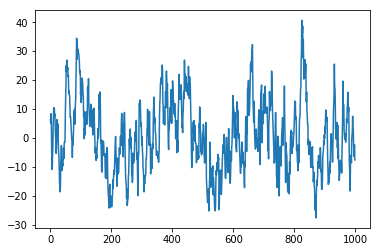

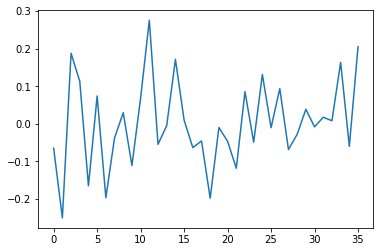

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [26/30], Iter [1/17] Loss: [----- 0.8087 = 0.8087 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [2/17] Loss: [----- 0.7942 = 0.7942 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [3/17] Loss: [----- 0.8604 = 0.8604 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [4/17] Loss: [----- 0.7333 = 0.7333 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [5/17] Loss: [----- 0.8546 = 0.8546 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [6/17] Loss: [----- 0.8338 = 0.8338 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [7/17] Loss: [----- 0.8309 = 0.8309 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [8/17] Loss: [----- 1.0667 = 1.0667 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [9/17] Loss: [----- 0.8448 = 0.8448 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [26/30], Iter [10/17] Loss: [----- 0.9337 = 0.9337 + 1.00 * 

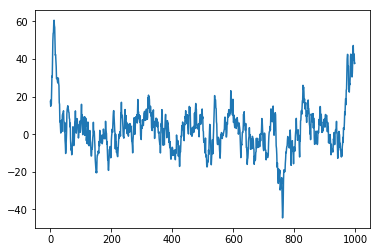

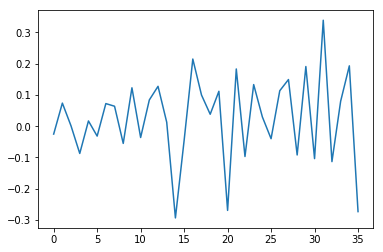

torch.Size([1775, 4])
Train Accuracy: 67 %


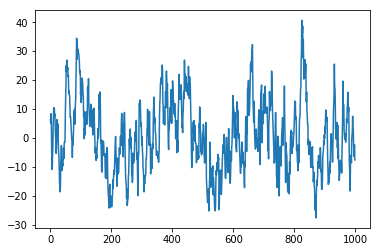

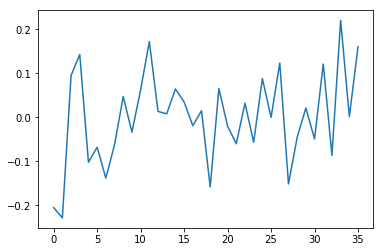

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 28 %
Epoch [27/30], Iter [1/17] Loss: [----- 0.7285 = 0.7285 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [2/17] Loss: [----- 0.8955 = 0.8955 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [3/17] Loss: [----- 0.8314 = 0.8314 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [4/17] Loss: [----- 0.7453 = 0.7453 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [5/17] Loss: [----- 0.8391 = 0.8391 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [6/17] Loss: [----- 0.9728 = 0.9728 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [7/17] Loss: [----- 0.8612 = 0.8612 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [8/17] Loss: [----- 0.7655 = 0.7655 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [9/17] Loss: [----- 0.9910 = 0.9910 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [27/30], Iter [10/17] Loss: [----- 0.8869 = 0.8869 + 1.00 * 

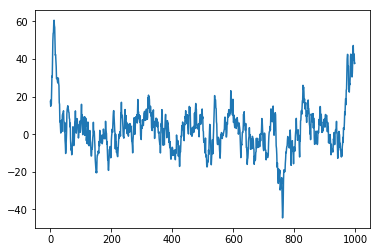

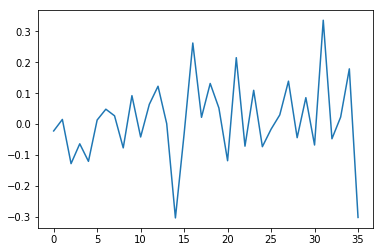

torch.Size([1775, 4])
Train Accuracy: 64 %


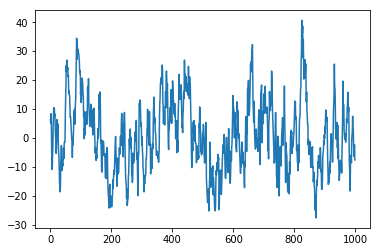

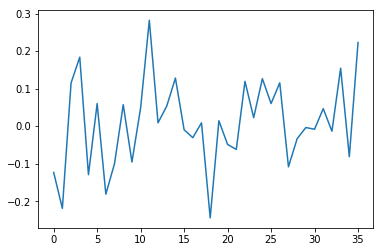

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 30 %
Epoch [28/30], Iter [1/17] Loss: [----- 0.8560 = 0.8560 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [2/17] Loss: [----- 0.7074 = 0.7074 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [3/17] Loss: [----- 0.8318 = 0.8318 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [4/17] Loss: [----- 0.7602 = 0.7602 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [5/17] Loss: [----- 0.8293 = 0.8293 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [6/17] Loss: [----- 0.7945 = 0.7945 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [7/17] Loss: [----- 0.8574 = 0.8574 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [8/17] Loss: [----- 0.6738 = 0.6738 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [9/17] Loss: [----- 0.8984 = 0.8984 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [28/30], Iter [10/17] Loss: [----- 0.8969 = 0.8969 + 1.00 * 

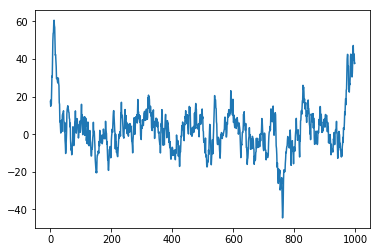

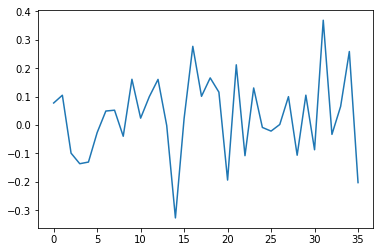

torch.Size([1775, 4])
Train Accuracy: 71 %


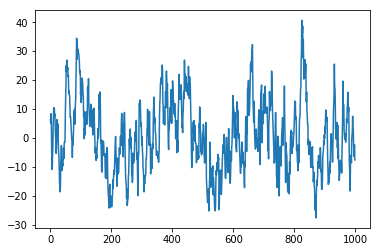

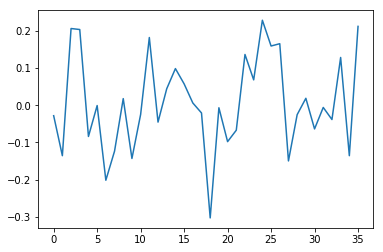

predicted set [0 1 2 3]
label set [0 1 2 3]
validation Accuracy: 29 %
Epoch [29/30], Iter [1/17] Loss: [----- 0.7571 = 0.7571 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [2/17] Loss: [----- 0.7724 = 0.7724 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [3/17] Loss: [----- 0.8656 = 0.8656 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [4/17] Loss: [----- 0.6631 = 0.6631 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [5/17] Loss: [----- 0.6921 = 0.6921 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [6/17] Loss: [----- 0.8021 = 0.8021 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [7/17] Loss: [----- 0.7588 = 0.7588 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [8/17] Loss: [----- 0.9206 = 0.9206 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [9/17] Loss: [----- 0.8539 = 0.8539 + 1.00 * 1.6046 + 0.01 * 30.1859 -----]
Epoch [29/30], Iter [10/17] Loss: [----- 0.7219 = 0.7219 + 1.00 * 

In [ ]:
import gc
gc.collect()

torch.manual_seed(1111)

train_acc = []
val_acc = []
loss_history = []
          
for epoch in range(num_epochs):

    ######################## TRAINING
        
    net.train(True)
    
    for i, (images, labels) in enumerate(train_loader):
        
        images = Variable(images, requires_grad=True) #unsqueeze used to make a 4d tensor because 
        
        if (VERBOSE):
            print('initial label shape: {}'.format(labels.shape))
            
        labels = Variable(labels)

        if (VERBOSE):
            print('iteration label set {}'.format(np.unique(labels.data)))
        
        # Forward + Backward + Optimize
        optimizer.zero_grad()
        
        if (FCC_SANITY):
            outputs = net(images)
        else:    
            outputs, hidden = net(images)

        _, predicted = torch.max(outputs.data, 1)
    
        if (VERBOSE):
            print('training predicted set {}'.format(np.unique(predicted.data)))
            print('training output shape: {}'.format(outputs.shape))
            print('training labels shape: {}'.format(labels.shape))
        
        loss1 = criterion(outputs, labels)
        loss1.backward(retain_graph=True)
        
        ## hidden state vanishing gradient regularizer
        #hidden_loss, size_loss = net.loss_regularizer()
        
        ## general weight l2 regularizer()
        
        loss = loss1 #+ reg_hidden_weight*hidden_loss + reg_weight_size*size_loss

        #loss = criterion(outputs, labels)

        loss_history.append(loss)
        loss.backward()
        
        nn.utils.clip_grad_norm(net.parameters(), 100)
        optimizer.step()
        
        print ('Epoch [%d/%d], Iter [%d/%d] Loss: [----- %.4f = %.4f + %.2f * %.4f + %.2f * %.4f -----]' 
               %(epoch+1, num_epochs, i+1, rnn_training_data_X.shape[0]*1.0/batch_size,
                 loss.data[0], loss1.data[0],
                 reg_hidden_weight, hidden_loss.data[0],
                 reg_weight_size, size_loss.data[0]))
    
    ######################## PER EPOCH EVALUATION
            
    bad_grads = []
    for n,p in net.named_parameters():
        grad_max = torch.max(p.grad)
        abs_grad_mean = torch.mean(torch.abs(p.grad))
        if (PRINT_GRADS):
            print('===========\ngradient:{}'.format(n))
            print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))
            
        stats = [n, grad_max, abs_grad_mean]
        
        if (abs_grad_mean < 1e-4):
            stats.append('SMALL')
            bad_grads.append(stats)
        elif (1 < abs_grad_mean):
            stats.append('BIG')
            bad_grads.append(stats)
            
    for n, grad_max, abs_grad_mean, descr in bad_grads:
        print('===========\n {} gradient:{}'.format(descr, n))
        print('---------\nmax: {}, mean: {}'.format(grad_max, abs_grad_mean))  
        
    if (VERBOSE):
        print('weight_hh_l0:')
        print(net.rnn_layer.state_dict()['weight_hh_l0'])

    
    net.train(False)
    
    images = Variable(torch.Tensor(rnn_training_data_X))
    test_labels = torch.LongTensor(rnn_training_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    print(outputs.shape)
    
    correct = 0
    total = 0
    _, predicted = torch.max(outputs.data, 1)
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('Train Accuracy: %d %%' % (100 * int(correct) / float(total)))
    train_acc.append((100 * correct / total))

    net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
    correct = 0
    total = 0
    images = Variable(torch.Tensor(rnn_validation_data_X))
    test_labels = torch.LongTensor(rnn_validation_data_Y)
    
    if (FCC_SANITY):
        outputs = net(images)
    else:
        outputs, hidden = net(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    print('predicted set {}'.format(np.unique(predicted.data)))
    print('label set {}'.format(np.unique(test_labels.data)))
    
    total += test_labels.size(0)
    correct += (predicted == test_labels).double().sum()
    print('validation Accuracy: %d %%' % (100.0 * int(correct) / float(total)))
    val_acc.append((100 * correct / total))

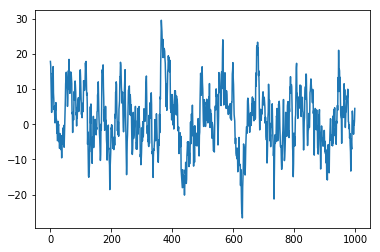

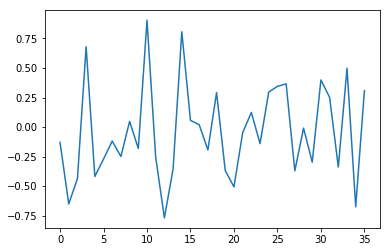

plotshape: torch.Size([443, 8, 36])
Test Accuracy of the model on the 10000 test images: 25 %


In [66]:

# Test the Model
net.eval()  # Change model to 'eval' mode (BN uses moving mean/var).
correct = 0
total = 0
images = Variable(torch.Tensor(rnn_test_data_X))
labels = torch.LongTensor(rnn_test_data_Y)
outputs, state = net(images)
_, predicted = torch.max(outputs.data, 1)
total += labels.size(0)
correct += (predicted == labels).sum()

print('Test Accuracy of the model on the 10000 test images: %d %%' % (100.0 * int(correct) / float(total)))

In [ ]:
l = list(net.layer1.modules())
print(l[1].running_mean)
print(l[1].running_var)